# LunarLander-v2 (Deep Q-Network)

Implemented a Deep Q-Network (DQN) to solve the LunarLander-v2 problem from OpenAI Gym. This project simulates an agent learning how to land a lunar module safely using Reinforcement Learning (RL) with deep learning.

## Project Aim

The goal of this project is to:

- Build an AI agent using Deep Q-Learning (DQN)

- Train it to play the LunarLander-v2 environment from OpenAI Gym

- The agent should learn to land safely by maximizing rewards over time through trial and error

## What is DQN?

DQN combines:

- Q-Learning (an RL algorithm)

- Neural Networks (to approximate the Q-function)

- Experience Replay (to stabilize training)

- Target Networks (to reduce overestimation and improve stability)

## What is OpenAI Gym?

OpenAI Gym is an open-source toolkit created by OpenAI for developing and comparing reinforcement learning (RL) algorithms. It provides:

- A wide range of environments for RL agents, including classic control problems, video games, robotics simulations, and more.

- A standardized interface for agents and environments, making it easy to test and benchmark RL algorithms.

- Simple APIs like .reset() and .step(action) that make it beginner-friendly but also powerful for research.

## What is LunarLander-v2?

LunarLander-v2 is a specific environment in OpenAI Gym where the goal is to land a spacecraft safely between two flags on the surface of the moon.

Environment details:

- Type: Discrete Action Space (4 actions)

- State Space: 8 continuous values representing the lander's position, velocity, angle, and leg contact.

- Action Space:

    - 0: Do nothing

    - 1: Fire left orientation engine

    - 2: Fire main engine

    - 3: Fire right orientation engine

Reward structure:

- +100 to +140 for a successful landing.

- -100 or more for crashing.

- -0.3 for firing a thruster (to encourage efficiency).

- +10 for each leg that touches the ground.

Goal:

Train an agent (neural network) to control the lander using only these actions and maximize cumulative reward.

## Imports and Envirnment

- Initializes the LunarLander environment with human-readable rendering.

- observation_space.shape[0]: Number of input values (state size)

- action_space.n: Number of discrete actions (4: do nothing, fire left/right engines, fire main engine)

In [39]:
# Imports & Env Setup
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm

# env = gym.make("LunarLander-v2", render_mode="human")
env = gym.make("LunarLander-v2")

print(f"State size: {env.observation_space.shape[0]}")
print(f"Action size: {env.action_space.n}")

State size: 8
Action size: 4


## Q-Network

- This is the neural network used to approximate Q-values for each state-action pair.

- Input: state (8 values)

- Output: Q-values for 4 actions

- Architecture: 2 hidden layers → ReLU → output layer

In [40]:
# DEEP Q-NETWORK MODEL
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.out = nn.Linear(hidden, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

## Replay Buffer

- Stores past experiences (state, action, reward, next_state, done)

- Used for experience replay: randomly samples past experiences for training

- This breaks temporal correlation and stabilizes learning

In [41]:
# REPLAY BUFFER
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        return len(self.buffer)

## Hyperparameters

- lr: Learning rate

- batch_size: Number of samples per training step

- gamma: Discount factor (future rewards)

- tau: Controls soft update rate

- eps: Controls exploration vs. exploitation (epsilon-greedy strategy)

## epsilon calculation

epsilon = eps_end + (eps_start - eps_end) * (eps_decay ** episode)

0.1 = 0.01 + 0.99 * (0.999 ^ episode)

→ (0.1 - 0.01)/0.99 = 0.999 ^ episode

→ 0.0909 ≈ 0.999 ^ episode

→ log(0.0909) / log(0.999) ≈ episode

→ episode ≈ 2400

In [42]:
# HYPERPARAMETERS
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

lr = 1e-4
batch_size = 64
gamma = 0.99
tau = 1e-3  # For soft update
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.999
buffer = ReplayBuffer()
# episodes = 1000
episodes = 2400

## Agent Setup

- q_net: Learns the Q-function

- target_net: Stabilizes learning (lagging behind q_net)

- soft_update: Slowly copies q_net weights to target_net every step

In [43]:
# DQN AGENT SETUP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_net = QNetwork(state_size, action_size).to(device)
target_net = QNetwork(state_size, action_size).to(device)
target_net.load_state_dict(q_net.state_dict())

optimizer = optim.Adam(q_net.parameters(), lr=lr)

def soft_update(local, target, tau):
    for target_param, local_param in zip(target.parameters(), local.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

## Training Loop

For each episode:

   1. Reset environment: get initial state

   2. Choose an action:

      - With probability eps, take random action (exploration)

      - Else, use q_net to choose best action (exploitation)

   3. Take action in environment → get (next_state, reward, done)

   4. Store transition in replay buffer

   5. If buffer has enough samples:

      - Sample a batch

      - Calculate target Q-values using target_net

      - Compute loss (MSE between predicted and target Q-values)

      - Backpropagate loss to update q_net

      - Soft-update target network

   6. Decay epsilon over time

In [44]:
# TRAINING LOOP
rewards = []
eps = eps_start

for ep in tqdm(range(episodes)):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        if random.random() < eps:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = q_net(state_tensor)
                action = q_values.argmax().item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Clip reward
        # reward = np.clip(reward, -1.0, 1.0)
        reward = np.clip(reward, -10, 10)

        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Only train when buffer is sufficiently filled
        if len(buffer) > 1000:
            # Sample mini-batch
            states, actions, rewards_batch, next_states, dones = buffer.sample(batch_size)

            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).unsqueeze(1).to(device)
            rewards_batch = torch.FloatTensor(rewards_batch).unsqueeze(1).to(device)
            next_states = torch.FloatTensor(next_states).to(device)
            dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

            # Q targets
            with torch.no_grad():
                target_q = target_net(next_states).max(1, keepdim=True)[0]
                target = rewards_batch + (gamma * target_q * (1 - dones))

            current_q = q_net(states).gather(1, actions)

            # Loss & optimize
            # loss = nn.MSELoss()(current_q, target)
            loss = nn.SmoothL1Loss()(current_q, target)
            optimizer.zero_grad()
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(q_net.parameters(), 1.0)

            optimizer.step()

            # Soft update
            soft_update(q_net, target_net, tau)

    eps = max(eps_end, eps_decay * eps)
    rewards.append(total_reward)

    if (ep+1) % 50 == 0:
        print(f"Episode {ep+1}, Avg Reward: {np.mean(rewards[-50:]):.2f}, Epsilon: {eps:.2f}")

  2%|█▋                                                                              | 50/2400 [00:05<05:12,  7.53it/s]

Episode 50, Avg Reward: -95.33, Epsilon: 0.95


  4%|███▎                                                                           | 101/2400 [00:14<05:42,  6.72it/s]

Episode 100, Avg Reward: -72.79, Epsilon: 0.90


  6%|████▉                                                                          | 151/2400 [00:22<05:53,  6.36it/s]

Episode 150, Avg Reward: -54.89, Epsilon: 0.86


  8%|██████▌                                                                        | 201/2400 [00:30<05:51,  6.26it/s]

Episode 200, Avg Reward: -22.46, Epsilon: 0.82


 10%|████████▎                                                                      | 251/2400 [00:39<05:44,  6.23it/s]

Episode 250, Avg Reward: -16.09, Epsilon: 0.78


 12%|█████████▉                                                                     | 300/2400 [00:49<05:19,  6.58it/s]

Episode 300, Avg Reward: 4.69, Epsilon: 0.74


 15%|███████████▌                                                                   | 350/2400 [00:59<05:27,  6.25it/s]

Episode 350, Avg Reward: 22.29, Epsilon: 0.70


 17%|█████████████▏                                                                 | 401/2400 [01:09<06:54,  4.82it/s]

Episode 400, Avg Reward: 22.52, Epsilon: 0.67


 19%|██████████████▊                                                                | 451/2400 [01:18<05:57,  5.45it/s]

Episode 450, Avg Reward: 22.52, Epsilon: 0.64


 21%|████████████████▍                                                              | 501/2400 [01:28<06:18,  5.02it/s]

Episode 500, Avg Reward: 31.23, Epsilon: 0.61


 23%|██████████████████▏                                                            | 551/2400 [01:38<05:11,  5.93it/s]

Episode 550, Avg Reward: 38.43, Epsilon: 0.58


 25%|███████████████████▊                                                           | 601/2400 [01:49<05:45,  5.21it/s]

Episode 600, Avg Reward: 17.66, Epsilon: 0.55


 27%|█████████████████████▍                                                         | 650/2400 [02:03<07:54,  3.69it/s]

Episode 650, Avg Reward: 37.97, Epsilon: 0.52


 29%|███████████████████████                                                        | 701/2400 [02:19<14:22,  1.97it/s]

Episode 700, Avg Reward: 31.91, Epsilon: 0.50


 31%|████████████████████████▋                                                      | 750/2400 [02:41<17:24,  1.58it/s]

Episode 750, Avg Reward: 39.55, Epsilon: 0.47


 33%|██████████████████████████▎                                                    | 801/2400 [03:06<09:31,  2.80it/s]

Episode 800, Avg Reward: 49.05, Epsilon: 0.45


 35%|███████████████████████████▉                                                   | 850/2400 [03:43<16:45,  1.54it/s]

Episode 850, Avg Reward: 43.75, Epsilon: 0.43


 38%|█████████████████████████████▋                                                 | 901/2400 [04:36<36:56,  1.48s/it]

Episode 900, Avg Reward: 51.89, Epsilon: 0.41


 40%|███████████████████████████████▎                                               | 950/2400 [05:34<41:11,  1.70s/it]

Episode 950, Avg Reward: 32.82, Epsilon: 0.39


 42%|████████████████████████████████▌                                             | 1000/2400 [06:48<39:47,  1.71s/it]

Episode 1000, Avg Reward: 53.57, Epsilon: 0.37


 44%|██████████████████████████████████▏                                           | 1050/2400 [07:47<27:12,  1.21s/it]

Episode 1050, Avg Reward: 41.55, Epsilon: 0.35


 46%|███████████████████████████████████▊                                          | 1100/2400 [08:52<20:58,  1.03it/s]

Episode 1100, Avg Reward: 103.22, Epsilon: 0.33


 48%|█████████████████████████████████████▍                                        | 1150/2400 [09:46<44:30,  2.14s/it]

Episode 1150, Avg Reward: 104.19, Epsilon: 0.32


 50%|███████████████████████████████████████                                       | 1200/2400 [10:37<21:47,  1.09s/it]

Episode 1200, Avg Reward: 108.91, Epsilon: 0.30


 52%|████████████████████████████████████████▋                                     | 1250/2400 [11:49<28:22,  1.48s/it]

Episode 1250, Avg Reward: 124.78, Epsilon: 0.29


 54%|██████████████████████████████████████████▎                                   | 1300/2400 [12:46<26:37,  1.45s/it]

Episode 1300, Avg Reward: 124.43, Epsilon: 0.27


 56%|███████████████████████████████████████████▉                                  | 1351/2400 [14:10<23:51,  1.36s/it]

Episode 1350, Avg Reward: 144.65, Epsilon: 0.26


 58%|█████████████████████████████████████████████▌                                | 1400/2400 [15:29<29:11,  1.75s/it]

Episode 1400, Avg Reward: 125.71, Epsilon: 0.25


 60%|███████████████████████████████████████████████▏                              | 1450/2400 [16:24<09:43,  1.63it/s]

Episode 1450, Avg Reward: 136.07, Epsilon: 0.23


 62%|████████████████████████████████████████████████▊                             | 1500/2400 [17:42<19:58,  1.33s/it]

Episode 1500, Avg Reward: 120.73, Epsilon: 0.22


 65%|██████████████████████████████████████████████████▍                           | 1550/2400 [18:44<23:23,  1.65s/it]

Episode 1550, Avg Reward: 148.52, Epsilon: 0.21


 67%|████████████████████████████████████████████████████                          | 1600/2400 [19:57<15:21,  1.15s/it]

Episode 1600, Avg Reward: 158.59, Epsilon: 0.20


 69%|█████████████████████████████████████████████████████▋                        | 1650/2400 [21:00<12:59,  1.04s/it]

Episode 1650, Avg Reward: 129.79, Epsilon: 0.19


 71%|███████████████████████████████████████████████████████▎                      | 1700/2400 [21:51<14:39,  1.26s/it]

Episode 1700, Avg Reward: 143.47, Epsilon: 0.18


 73%|████████████████████████████████████████████████████████▉                     | 1750/2400 [22:45<10:04,  1.08it/s]

Episode 1750, Avg Reward: 139.49, Epsilon: 0.17


 75%|██████████████████████████████████████████████████████████▌                   | 1800/2400 [24:05<15:07,  1.51s/it]

Episode 1800, Avg Reward: 142.31, Epsilon: 0.17


 77%|████████████████████████████████████████████████████████████▏                 | 1850/2400 [25:23<21:36,  2.36s/it]

Episode 1850, Avg Reward: 142.80, Epsilon: 0.16


 79%|█████████████████████████████████████████████████████████████▊                | 1900/2400 [26:37<07:49,  1.07it/s]

Episode 1900, Avg Reward: 147.65, Epsilon: 0.15


 81%|███████████████████████████████████████████████████████████████▍              | 1950/2400 [27:45<08:49,  1.18s/it]

Episode 1950, Avg Reward: 142.87, Epsilon: 0.14


 83%|█████████████████████████████████████████████████████████████████             | 2000/2400 [28:42<05:21,  1.24it/s]

Episode 2000, Avg Reward: 136.29, Epsilon: 0.14


 85%|██████████████████████████████████████████████████████████████████▋           | 2050/2400 [29:32<03:38,  1.60it/s]

Episode 2050, Avg Reward: 144.66, Epsilon: 0.13


 88%|████████████████████████████████████████████████████████████████████▎         | 2100/2400 [30:12<02:45,  1.81it/s]

Episode 2100, Avg Reward: 119.49, Epsilon: 0.12


 90%|█████████████████████████████████████████████████████████████████████▉        | 2150/2400 [30:34<01:20,  3.12it/s]

Episode 2150, Avg Reward: 112.52, Epsilon: 0.12


 92%|███████████████████████████████████████████████████████████████████████▌      | 2200/2400 [30:54<00:59,  3.35it/s]

Episode 2200, Avg Reward: 103.95, Epsilon: 0.11


 94%|█████████████████████████████████████████████████████████████████████████▏    | 2250/2400 [31:07<00:36,  4.08it/s]

Episode 2250, Avg Reward: 85.81, Epsilon: 0.11


 96%|██████████████████████████████████████████████████████████████████████████▊   | 2300/2400 [31:29<01:35,  1.05it/s]

Episode 2300, Avg Reward: 100.81, Epsilon: 0.10


 98%|████████████████████████████████████████████████████████████████████████████▍ | 2350/2400 [31:56<00:13,  3.63it/s]

Episode 2350, Avg Reward: 113.87, Epsilon: 0.10


100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [32:36<00:00,  1.23it/s]

Episode 2400, Avg Reward: 129.88, Epsilon: 0.09


## Visualization

- Plots reward per episode

- Also shows a smoothed average over the last 50 episodes

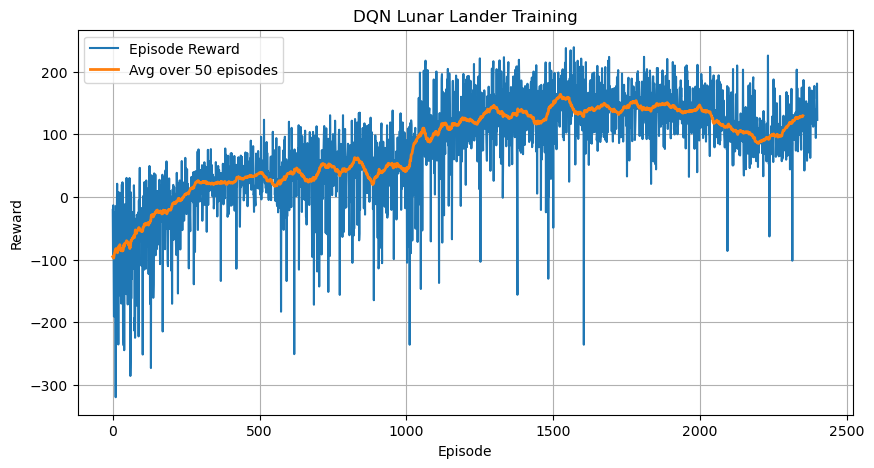

In [45]:
# VISUALIZATION
plt.figure(figsize=(10,5))
plt.plot(rewards, label="Episode Reward")
plt.plot(np.convolve(rewards, np.ones(50)/50, mode='valid'), label="Avg over 50 episodes", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("DQN Lunar Lander Training")
plt.legend()
plt.grid()
plt.show()

## Play Function

- Lets the trained agent play without exploration

- Uses the q_net to select the best action

- Renders the environment visually

- Shows total reward earned in each episode

In [46]:
# PLAY TRAINED AGENT
def play(env, agent, episodes=5):
    env = gym.make("LunarLander-v2", render_mode="human")
    
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action = agent(state_tensor).argmax().item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward
        print(f"Episode {ep+1} Reward: {total_reward}")
    env.close()

# Run after training:
play(env, q_net)

Episode 1 Reward: 240.10743291296916
Episode 2 Reward: 246.03374685696483
Episode 3 Reward: 120.2279850943359
Episode 4 Reward: 281.4993702231069
Episode 5 Reward: 147.37552667774162
